In [1]:
import warnings
from pandas_datareader.wb import WorldBankReader, get_indicators
import statsmodels.api as sm
import pandas as pd

In [2]:
indicators = get_indicators()
indicators_df = pd.DataFrame(indicators)
#indicators_df.head(50)

In [3]:

gdp = WorldBankReader(symbols='NY.GDP.MKTP.CN', countries= 'KE', start=2000, end=2020).read()


In [4]:
# kenya's GDP for the last 20 years
gdp.head()

NY.GDP.MKTP.CN
country year                
Kenya   2020  10715070000000
        2019  10237727000000
        2018   9340307000000
        2017   8483396000000
        2016   7594064000000

In [5]:
import matplotlib.pyplot as plt

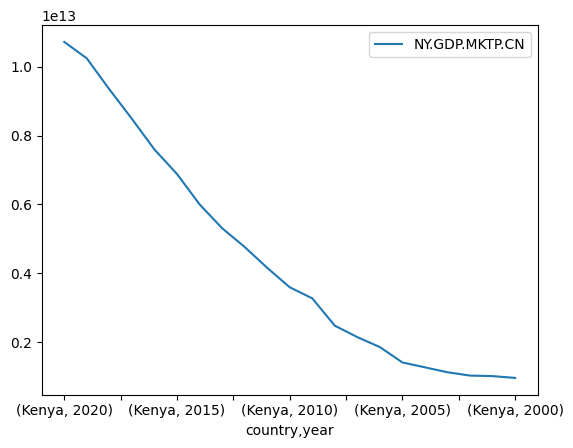

In [6]:
fig, ax = plt.subplots()
gdp.plot(ax=ax)
plt.show()

In [7]:
# The gdp series is clearly not stationary. we can also do the dicky fuller test for stationarity.
# null hypothesis is that the time series is not stationary

from statsmodels.tsa.stattools import adfuller

result = adfuller(gdp)

# Print the test statistic and the p-value. p-value is less than 0.05 we accept the null that series isn't stationary
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -5.659759396600234
p-value: 9.438979108992121e-07


In [8]:
# compute the first difference to make the series stationary.but there's still some stationarity therefore take second diff
gdp_diff = gdp.diff().diff().dropna()


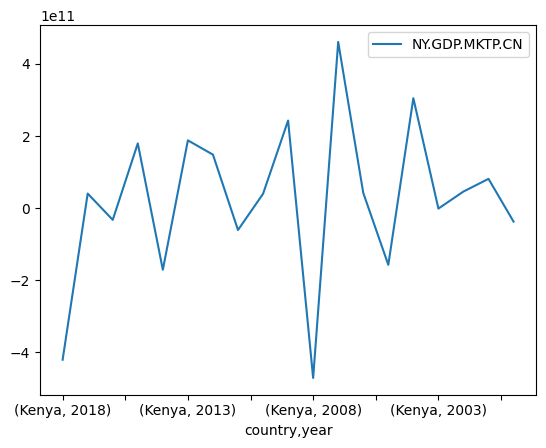

In [9]:
fig, ax = plt.subplots()
gdp_diff.plot(ax=ax)
plt.show()

In [10]:
# Let's try the log transformation
import numpy as np

gdp_log = np.log(gdp/gdp.shift(1)).dropna()

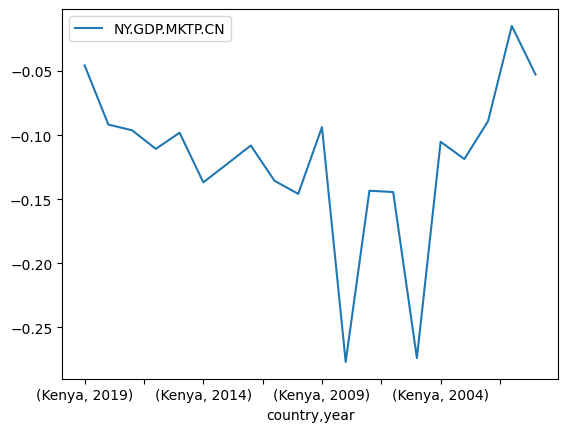

In [11]:
fig, ax = plt.subplots()
gdp_log.plot(ax=ax)
plt.show()

In [12]:
result1 = adfuller(gdp_diff)
result2 = adfuller(gdp_log)


In [13]:
""" when we compare the p-values of both transformations, the logarithm is greater than 0.05( Reject the null-- not stationary) meaning it is a better transformation 
in making our series stationary. that is what we shall use to fit the ARMA model.
"""

print(f"AdfullerStatistic: diff= {result1[0]} : log= {result2[0]}")
print(f"Pvalue:diff= {result1[1]}: log= {result2[1]}")

AdfullerStatistic: diff= -6.564724564198561 : log= -1.7207455647146852
Pvalue:diff= 8.213331216641096e-09: log= 0.4204566773885044


Fitting the ARMA model

In [14]:
gdp_log.head()

NY.GDP.MKTP.CN
country year                
Kenya   2019       -0.045572
        2018       -0.091741
        2017       -0.096228
        2016       -0.110744
        2015       -0.098121

In [15]:
# preapre the gdp_log df for modelling

# Drop country name from index
gdp_log= gdp_log.droplevel(level=0, axis=0)

In [16]:
gdp_log.head()

,NY.GDP.MKTP.CN
year,
2019,-0.045572
2018,-0.091741
2017,-0.096228
2016,-0.110744
2015,-0.098121


In [17]:
# Sort data in choronological order and set data point at year-end
gdp_log = gdp_log.set_index(pd.to_datetime(gdp_log.index))
gdp_log = gdp_log.sort_index().resample("y").last()

In [18]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
#warnings.simplefilter("ignore")

# instantiate an object

model = ARIMA(endog=gdp_log , order = (1,2,1))

# fit model
results = model.fit()

In [19]:
# Forecast, and calculate the relative error
forecast = results.forecast(steps=4)
#df = pd.DataFrame({"Actual":gdp, "Forecast":forecast}).dropna()

In [20]:
print(forecast)

2020-12-31   -0.070428
2021-12-31   -0.059522
2022-12-31   -0.066623
2023-12-31   -0.064657
Freq: A-DEC, Name: predicted_mean, dtype: float64


In [21]:
# kenya's GDP forecast for 2020
forecast_20  = 10 ** forecast[0]
print(forecast_20)

0.850299854789367
